In [5]:
from __future__ import division
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.transform as transform
from skimage import img_as_ubyte
import tifffile as tif

from keras.models import load_model
from keras.backend import binary_crossentropy
from keras import backend as K

os.system('export LD_LIBRARY_PATH=/usr/local/cuda-8.0/lib64')
os.environ['KERAS_BACKEND']='tensorflow'
os.environ['PATH']='/usr/local/cuda-8.0/bin'
os.environ['LD_LIBRARY_PATH']='/usr/local/cuda-8.0/lib64'
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

K.set_image_dim_ordering('tf')

IMAGE_SIZE = 1024
MASK_SIZE = 1000
PAD_SIZE = 12
WEIGHT_PATH = [
    "../checkpoints/0Building/weights.182-0.49.hdf5",
     "../checkpoints/1Tree/weights.160-0.78.hdf5",
     "../checkpoints/2Grass/weights.157-0.82.hdf5",
     "../checkpoints/3Unknown/weights.155-3.74.hdf5",
     "../checkpoints/4Car/weights.183-0.10.hdf5",
     "../checkpoints/5Road/weights.195-0.56.hdf5"
]
IMAGE_PATH = '../data/image_canada/top_potsdam_5_12_RGBIR.tif'
MASK_PATH = '../data/mask_canada/top_potsdam_5_12_label.tif'
MASK_DIR = '../data/mask_canada/'
IMAGE_DIR = '../data/image_canada/'
OUTPUT_PATH = '../predictions/'

smooth = 1e-12

In [2]:
% matplotlib inline 
IMAGE_PATH = '../data/data_1024_resize/0.tif'
MASK_PATH = '../data/data_1024_resize/0_mask.tif'

image = tif.imread(IMAGE_PATH)
mask = tif.imread(MASK_PATH)

In [20]:
np.unique(mask[np.random.randint()], axis=0)

TypeError: randint() takes at least 1 positional argument (0 given)

# Model Class

In [25]:
class Model():
    """ unet model
    """

    def __init__(self, weight_paths=None):
        """ Load weights from every category
        Form len(category) binary classifiers

        :param wegith_paths: list of weight path of weights from every weight path
        """
        self.weight_paths = weight_paths
        self.custom_objects = {
            u'jaccard_coef_loss': self._jaccard_coef_loss,
            u'jaccard_coef_int': self._jaccard_coef_int
        }
        self.category_code = {
            0: [0, 0, 255],
            1: [0, 255, 0],
            2: [0, 255, 255],
            3: [255, 0, 0],
            4: [255, 255, 0],
            5: [255, 255, 255],
        }
        # every binary classifier for categories
        self.models = [load_model(path, custom_objects=self.custom_objects) for path in self.weight_paths]
        print " ===> model loaded"

    def predict(self, image):
        """ Predict mask of image

        :param image: image in numpy array with size (H, W, Channels)
        :return: list of binary masks in numpy array format (Categories, H, W)
        """
        height, width = image.shape[:2]
        masks = np.zeros(shape=(height, width, len(self.models)))
        image = self._normalize_image(image)  # normalization
        image = np.pad(image, ((PAD_SIZE, PAD_SIZE), (PAD_SIZE, PAD_SIZE), (0, 0)), 'constant', constant_values=0)  # padding

        pad_size_half = int(IMAGE_SIZE / 2)
        mask_size_half = int(MASK_SIZE / 2)
        overlap_size = pad_size_half - mask_size_half

        for i in tqdm(range(pad_size_half, height, MASK_SIZE)):
            for j in range(pad_size_half, width, MASK_SIZE):
                y1_image = i - pad_size_half
                y2_image = i + pad_size_half
                x1_image = j - pad_size_half
                x2_image = j + pad_size_half

                image_clip = image[y1_image:y2_image, x1_image:x2_image, :]
                print image_clip.shape
                res = [self._bin_mask(model.predict(image_clip[np.newaxis, ...])) for model in self.models]

                y1_mask = i - mask_size_half - overlap_size
                y2_mask = i + mask_size_half - overlap_size
                x1_mask = j - mask_size_half - overlap_size
                x2_mask = j + mask_size_half - overlap_size

                for k in range(len(self.models)):
                    masks[y1_mask:y2_mask, x1_mask:x2_mask, k] = np.squeeze(res[k])

        return masks
    
    def predict_one_vs_all(self, image):
        """ Predict mask of image

        :param image: image in numpy array with size (H, W, Channels)
        :return: list of binary masks in numpy array format (Categories, H, W)
        """
        height, width = image.shape[:2]
        mask = np.zeros(shape=(height, width))
        image = self._normalize_image(image)  # normalization
        image = np.pad(image, ((PAD_SIZE, PAD_SIZE), (PAD_SIZE, PAD_SIZE), (0, 0)), 'constant', constant_values=0)  # padding

        pad_size_half = int(IMAGE_SIZE / 2)
        mask_size_half = int(MASK_SIZE / 2)
        overlap_size = pad_size_half - mask_size_half

        for i in tqdm(range(pad_size_half, height, MASK_SIZE)):
            for j in range(pad_size_half, width, MASK_SIZE):
                y1_image = i - pad_size_half
                y2_image = i + pad_size_half
                x1_image = j - pad_size_half
                x2_image = j + pad_size_half

                image_clip = image[y1_image:y2_image, x1_image:x2_image, :]
                print image_clip.shape
                res = [self._bin_mask(model.predict(image_clip[np.newaxis, ...])) for model in self.models]
                res = np.argmax(np.array(res), axis=0)

                y1_mask = i - mask_size_half - overlap_size
                y2_mask = i + mask_size_half - overlap_size
                x1_mask = j - mask_size_half - overlap_size
                x2_mask = j + mask_size_half - overlap_size

                mask[y1_mask:y2_mask, x1_mask:x2_mask] = np.squeeze(res)

        return mask

    def predict_visualize(self, image):
        """ Get the predicted masks and visualize them in Jupyter Notebook
        Image and masks all will be visualized

        :param image: raw image
        """
        masks = self.predict(image)
        plt.figure(figsize=(16, 16))
        plt.title("Image")
        plt.imshow(image[..., :3])
        plt.show()

        plt.figure(figsize=(16, 16))
        for i in range(len(self.weight_paths)):
            plt.subplot(2, 3, i + 1)
            plt.title(self.weight_paths[i])
            plt.imshow(masks[..., i])
        plt.show()

    def predict_visualize_RGB(self, image, mask_gt=None, masks_pred = None, order=(3, 5, 0, 1, 2, 4), jaccard=False, save_path = None):
        """ Viusalize the raw image, ground truth and predicted mask
        Mask overlap order: Unknown, Road, Building, Grass, Tree, Car

        :param image: raw image in numpy (N, H, W, C)
        :param mask: mask ground truth in numpy (N, H, W, C)
        """
        
        if order is None:
            masks_pred = self.predict_one_vs_all(image)
            height, width = masks_pred.shape
            mask_pred = np.zeros(shape=(height, width, 3), dtype=np.uint8)
            mask_pred.fill(249)
            # use category color code to colorate the mask_pred
            for i in range(len(self.models)):
                mask_category = (masks_pred == i)
                colors = self.category_code[i]
                for channel, color in enumerate(colors):
                    mask_pred[..., channel][mask_category.astype(np.bool)] = color

        else:
            if masks_pred is None:
                masks_pred = self.predict(image)
            height, width = masks_pred.shape[:2]
            mask_pred = np.zeros(shape=(height, width, 3), dtype=np.uint8)
            mask_pred.fill(249)
            # use category color code to colorate the mask_pred
            for i in order:
                mask_category = masks_pred[..., i]
                colors = self.category_code[i]
                for channel, color in enumerate(colors):
                    mask_pred[..., channel][mask_category.astype(np.bool)] = color

        # plot image, mask_gt, mask_pred
        plt.figure(figsize=(16, 6))

        # plot image
        if mask_gt is None:
            plt.subplot(1, 2, 1)
        else:
            plt.subplot(1, 3, 1)
        plt.title("Image")
        plt.imshow(image[..., :3])

        # plot mask_pred
        if mask_gt is None:
            plt.subplot(1, 2, 2)
        else:
            plt.subplot(1, 3, 2)
        plt.title("Mask_pred")
        plt.imshow(mask_pred)

        # plot mask_gt
        if mask_gt is None:
            plt.show()
            return
        else:
            plt.subplot(1, 3, 3)
            plt.title("Mask_gt")
            plt.imshow(mask_gt)

        # show all
        if save_path is None:
            plt.show()
        else:
            plt.savefig(save_path)

        jaccards = []
        # compute jaccard index
        if mask_gt is not None and jaccard:
            masks_pred = self._rgb2masks(mask_pred)
            masks_gt = self._rgb2masks(mask_gt)

            for i in range(len(self.models)):
                jaccards.append(self._jaccard_index(masks_gt[..., i], masks_pred[..., i]))
            return jaccards

    def _rgb2masks(self, mask):
        height, width = mask.shape[:2]
        masks = np.zeros(shape=(height, width, len(self.models)), dtype=np.bool)
        for i in range(len(self.models)):
            R, G, B = self.category_code[i]
            masks[..., i] = (mask[..., 0] == R) & (mask[..., 1] == G) & (mask[..., 2] == B)
        return masks

    def _normalize_image(self, image):
        """ Normalize the input image

        :param image: image in numpy array
        :return: normalized image with the same size
        :rtype: numpy array
        """
        image = image.astype(np.float32)
        image = (image - image.min()) / (image.max() - image.min())
        return image

    def _bin_mask(self, image):
        """ Clip the image into binary image
        When pixel in [0, 0.5) => 0, else => 1

        :param image: image numpy array
        :return: binary image
        """
        return (np.clip(image, 0, 1)>0.2)

    """ Jaccard loss and metric
    Credicted to http://blog.kaggle.com/2017/05/09/dstl-satellite
    -imagery-competition-3rd-place-winners-interview-vladimir-sergey/
    """

    def _jaccard_coef(self, y_true, y_pred):
        intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
        sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

        jac = (intersection + smooth) / (sum_ - intersection + smooth)

        return K.mean(jac)

    def _jaccard_coef_int(self, y_true, y_pred):
        y_pred_pos = K.round(K.clip(y_pred, 0, 1))

        intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
        sum_ = K.sum(y_true + y_pred_pos, axis=[0, -1, -2])

        jac = (intersection + smooth) / (sum_ - intersection + smooth)

        return K.mean(jac)

    def _jaccard_coef_loss(self, y_true, y_pred):
        return -K.log(self._jaccard_coef(y_true, y_pred)) + binary_crossentropy(y_pred, y_true)

    def _jaccard_index(self, y_true, y_pred):
        intersection = (y_true & y_pred).sum()
        sum_ = (y_true | y_pred).sum()

        jaccard = (intersection + smooth) / (sum_ + smooth)

        return jaccard

In [26]:
% matplotlib inline

model = Model(WEIGHT_PATH)

 ===> model loaded


  0%|          | 0/3 [00:00<?, ?it/s]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 33%|███▎      | 1/3 [00:33<01:07, 33.75s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 67%|██████▋   | 2/3 [00:35<00:17, 17.91s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


100%|██████████| 3/3 [00:37<00:00, 12.63s/it]


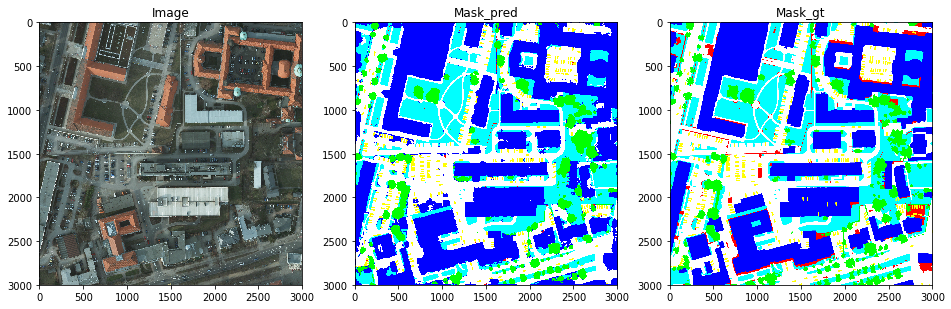

[0.84633366297536661, 0.6940049151185218, 0.80449893085668234, 0.051839810607135481, 0.81560800535824862, 0.83210011675194762]


In [27]:
IMAGE_PATH = '../data/image_canada/top_potsdam_4_12_RGBIR.tif'
MASK_PATH = '../data/mask_canada/top_potsdam_4_12_label.tif'
image = transform.resize(tif.imread(IMAGE_PATH), [3000,3000,4])
mask = img_as_ubyte(transform.resize(tif.imread(MASK_PATH), [3000,3000,3]))
print model.predict_visualize_RGB(image, mask, jaccard=True, order=None)

In [18]:
import pandas as pd


In [3]:
def plot(image):
    plt.figure(figsize=(16,16))
    plt.imshow(image)
    plt.show()

top_potsdam_5_12_label.tif


  0%|          | 0/3 [00:00<?, ?it/s]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 33%|███▎      | 1/3 [00:02<00:04,  2.07s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 67%|██████▋   | 2/3 [00:04<00:02,  2.06s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


100%|██████████| 3/3 [00:06<00:00,  2.06s/it]


[0.85436785193821629, 0.61246235268075744, 0.60281808743247833, 0.059238266056909572, 0.71648204205186938, 0.74532148077597216]
top_potsdam_5_11_label.tif


  0%|          | 0/3 [00:00<?, ?it/s]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 33%|███▎      | 1/3 [00:02<00:04,  2.08s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 67%|██████▋   | 2/3 [00:04<00:02,  2.08s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


100%|██████████| 3/3 [00:06<00:00,  2.08s/it]


[0.81823124798607572, 0.65541586090184711, 0.64160669573056173, 0.050464385752032756, 0.76369545601162847, 0.77161669091932206]
top_potsdam_5_10_label.tif


  0%|          | 0/3 [00:00<?, ?it/s]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 33%|███▎      | 1/3 [00:02<00:04,  2.04s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 67%|██████▋   | 2/3 [00:04<00:02,  2.05s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


100%|██████████| 3/3 [00:06<00:00,  2.05s/it]


[0.68991494461041347, 0.67266239433652508, 0.68335566589095675, 0.056529063794214678, 0.81875747760366513, 0.77671648424912498]
top_potsdam_4_12_label.tif


  0%|          | 0/3 [00:00<?, ?it/s]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 33%|███▎      | 1/3 [00:02<00:04,  2.07s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 67%|██████▋   | 2/3 [00:04<00:02,  2.07s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


100%|██████████| 3/3 [00:06<00:00,  2.06s/it]


[0.84633366297536661, 0.6940049151185218, 0.80449893085668234, 0.051839810607135481, 0.81560800535824862, 0.83210011675194762]
top_potsdam_4_11_label.tif


  0%|          | 0/3 [00:00<?, ?it/s]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 33%|███▎      | 1/3 [00:02<00:04,  2.05s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 67%|██████▋   | 2/3 [00:04<00:02,  2.06s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


100%|██████████| 3/3 [00:06<00:00,  2.07s/it]


[0.78438612759131587, 0.71292978414811026, 0.69596057308777703, 0.088529066324020994, 0.73743214927983369, 0.69233462385383593]
top_potsdam_4_10_label.tif


  0%|          | 0/3 [00:00<?, ?it/s]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 33%|███▎      | 1/3 [00:02<00:04,  2.06s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 67%|██████▋   | 2/3 [00:04<00:02,  2.07s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


100%|██████████| 3/3 [00:06<00:00,  2.08s/it]


[0.69511600249400218, 0.67709102204806915, 0.71340563264268197, 0.04315216877158129, 0.72889732933912865, 0.72428191917984119]
top_potsdam_3_12_label.tif


  0%|          | 0/3 [00:00<?, ?it/s]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 33%|███▎      | 1/3 [00:02<00:04,  2.08s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 67%|██████▋   | 2/3 [00:04<00:02,  2.07s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


100%|██████████| 3/3 [00:06<00:00,  2.07s/it]


[0.71533560949478037, 0.73872087183607871, 0.68010174644975863, 0.040211210398050375, 0.69440359725344836, 0.77396932383413297]
top_potsdam_3_11_label.tif


  0%|          | 0/3 [00:00<?, ?it/s]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 33%|███▎      | 1/3 [00:02<00:04,  2.05s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 67%|██████▋   | 2/3 [00:04<00:02,  2.06s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


100%|██████████| 3/3 [00:06<00:00,  2.07s/it]


[0.62992489625069104, 0.71581163736974451, 0.7484729774852128, 0.037067064286240743, 0.7238137099394194, 0.74547693132143533]
top_potsdam_3_10_label.tif


  0%|          | 0/3 [00:00<?, ?it/s]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 33%|███▎      | 1/3 [00:02<00:04,  2.07s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 67%|██████▋   | 2/3 [00:04<00:02,  2.07s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


100%|██████████| 3/3 [00:06<00:00,  2.08s/it]


[0.6106719145676609, 0.69921393141558086, 0.72277353486094742, 0.052602237629599251, 0.76760600942305979, 0.72268972693502831]
top_potsdam_7_11_label.tif


  0%|          | 0/3 [00:00<?, ?it/s]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 33%|███▎      | 1/3 [00:02<00:04,  2.08s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 67%|██████▋   | 2/3 [00:04<00:02,  2.09s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


100%|██████████| 3/3 [00:06<00:00,  2.09s/it]


[0.74393413007013987, 0.56782783916863833, 0.65314870449366502, 0.052418181062086754, 0.73983160534136672, 0.82518014793766925]
top_potsdam_7_10_label.tif


  0%|          | 0/3 [00:00<?, ?it/s]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 33%|███▎      | 1/3 [00:02<00:04,  2.07s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 67%|██████▋   | 2/3 [00:04<00:02,  2.07s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


100%|██████████| 3/3 [00:06<00:00,  2.07s/it]


[0.2958850761066934, 0.65860025687758417, 0.4759035036066539, 0.0020548896954052909, 0.76234024569275061, 0.74432293759465895]
top_potsdam_7_9_label.tif


  0%|          | 0/3 [00:00<?, ?it/s]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 33%|███▎      | 1/3 [00:02<00:04,  2.08s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 67%|██████▋   | 2/3 [00:04<00:02,  2.08s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


100%|██████████| 3/3 [00:06<00:00,  2.08s/it]


[0.55926183458958767, 0.68059986630937264, 0.6102771469631445, 0.0072356101490202458, 0.72795190789580766, 0.76998464513044418]
top_potsdam_7_8_label.tif


  0%|          | 0/3 [00:00<?, ?it/s]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 33%|███▎      | 1/3 [00:02<00:04,  2.07s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 67%|██████▋   | 2/3 [00:04<00:02,  2.07s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


100%|██████████| 3/3 [00:06<00:00,  2.08s/it]


[0.68549410754028173, 0.67727471914100845, 0.60435386224369547, 0.082738253733872336, 0.74088892239429638, 0.58576603623516665]
top_potsdam_7_7_label.tif


  0%|          | 0/3 [00:00<?, ?it/s]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 33%|███▎      | 1/3 [00:02<00:04,  2.07s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 67%|██████▋   | 2/3 [00:04<00:02,  2.07s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


100%|██████████| 3/3 [00:06<00:00,  2.07s/it]


[0.74377143177580574, 0.61130306445792681, 0.68854217998039702, 0.02110213643833701, 0.79579986399761993, 0.58780391078501804]
top_potsdam_6_12_label.tif


  0%|          | 0/3 [00:00<?, ?it/s]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 33%|███▎      | 1/3 [00:02<00:04,  2.06s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 67%|██████▋   | 2/3 [00:04<00:02,  2.08s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


100%|██████████| 3/3 [00:06<00:00,  2.08s/it]


[0.84137809615809001, 0.7273620825093422, 0.62738371093954037, 0.15344899238566165, 0.81028420673941715, 0.77521697726541083]
top_potsdam_6_11_label.tif


  0%|          | 0/3 [00:00<?, ?it/s]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 33%|███▎      | 1/3 [00:02<00:04,  2.07s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 67%|██████▋   | 2/3 [00:04<00:02,  2.07s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


100%|██████████| 3/3 [00:06<00:00,  2.07s/it]


[0.79576136607349546, 0.68219201193991108, 0.61164611480545616, 0.035634610684402941, 0.78085379148833078, 0.78287508655868643]
top_potsdam_6_10_label.tif


  0%|          | 0/3 [00:00<?, ?it/s]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 33%|███▎      | 1/3 [00:02<00:04,  2.07s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 67%|██████▋   | 2/3 [00:04<00:02,  2.07s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


100%|██████████| 3/3 [00:06<00:00,  2.07s/it]


[0.74438028677834078, 0.69731552488030413, 0.58509446366441697, 0.041629199903311577, 0.78090248577950261, 0.81572243595435956]
top_potsdam_6_9_label.tif


  0%|          | 0/3 [00:00<?, ?it/s]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 33%|███▎      | 1/3 [00:02<00:04,  2.06s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 67%|██████▋   | 2/3 [00:04<00:02,  2.06s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


100%|██████████| 3/3 [00:06<00:00,  2.06s/it]


[0.63706723704210677, 0.69405726630860842, 0.66156411334569043, 0.025983072636350777, 0.78183112004102173, 0.73751040595833706]
top_potsdam_6_8_label.tif


  0%|          | 0/3 [00:00<?, ?it/s]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 33%|███▎      | 1/3 [00:02<00:04,  2.09s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 67%|██████▋   | 2/3 [00:04<00:02,  2.08s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


100%|██████████| 3/3 [00:06<00:00,  2.08s/it]


[0.66198057936711974, 0.72422364368773762, 0.71544384390758986, 0.19269223830391488, 0.75783441669517615, 0.69372511661903558]
top_potsdam_6_7_label.tif


  0%|          | 0/3 [00:00<?, ?it/s]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 33%|███▎      | 1/3 [00:02<00:04,  2.06s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 67%|██████▋   | 2/3 [00:04<00:02,  2.06s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


100%|██████████| 3/3 [00:06<00:00,  2.07s/it]


[0.47028338638517503, 0.51805477659934496, 0.67064291519548336, 0.046007312736269561, 0.74683400048433735, 0.47707104160942426]
top_potsdam_2_12_label.tif


  0%|          | 0/3 [00:00<?, ?it/s]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 33%|███▎      | 1/3 [00:02<00:04,  2.08s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 67%|██████▋   | 2/3 [00:04<00:02,  2.08s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


100%|██████████| 3/3 [00:06<00:00,  2.08s/it]


[0.57928974850883275, 0.57222283535328733, 0.81840590839709126, 0.075596126479469658, 0.66903846840307934, 0.739273207285992]
top_potsdam_2_11_label.tif


  0%|          | 0/3 [00:00<?, ?it/s]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 33%|███▎      | 1/3 [00:02<00:04,  2.07s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 67%|██████▋   | 2/3 [00:04<00:02,  2.08s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


100%|██████████| 3/3 [00:06<00:00,  2.07s/it]


[0.36481699812475005, 0.65699325043684575, 0.67947923744324923, 0.035692607202954522, 0.7457712871422516, 0.69462737319094836]
top_potsdam_2_10_label.tif


  0%|          | 0/3 [00:00<?, ?it/s]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 33%|███▎      | 1/3 [00:02<00:04,  2.06s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 67%|██████▋   | 2/3 [00:04<00:02,  2.07s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


100%|██████████| 3/3 [00:06<00:00,  2.08s/it]


[0.4391674128003229, 0.6122538552787663, 0.73514608726971298, 0.048190074678658774, 0.6790656552713854, 0.69715714667812034]
top_potsdam_7_12_label.tif


  0%|          | 0/3 [00:00<?, ?it/s]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 33%|███▎      | 1/3 [00:02<00:04,  2.07s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


 67%|██████▋   | 2/3 [00:04<00:02,  2.06s/it]

(1024, 1024, 4)
(1024, 1024, 4)
(1024, 1024, 4)


100%|██████████| 3/3 [00:06<00:00,  2.08s/it]


[0.64406174890186341, 0.57331517408786847, 0.49727839474223196, 0.059968175304986666, 0.73334828436869248, 0.66645343334139062]
[[0.85436785193821629, 0.61246235268075744, 0.60281808743247833, 0.059238266056909572, 0.71648204205186938, 0.74532148077597216], [0.81823124798607572, 0.65541586090184711, 0.64160669573056173, 0.050464385752032756, 0.76369545601162847, 0.77161669091932206], [0.68991494461041347, 0.67266239433652508, 0.68335566589095675, 0.056529063794214678, 0.81875747760366513, 0.77671648424912498], [0.84633366297536661, 0.6940049151185218, 0.80449893085668234, 0.051839810607135481, 0.81560800535824862, 0.83210011675194762], [0.78438612759131587, 0.71292978414811026, 0.69596057308777703, 0.088529066324020994, 0.73743214927983369, 0.69233462385383593], [0.69511600249400218, 0.67709102204806915, 0.71340563264268197, 0.04315216877158129, 0.72889732933912865, 0.72428191917984119], [0.71533560949478037, 0.73872087183607871, 0.68010174644975863, 0.040211210398050375, 0.69440359725

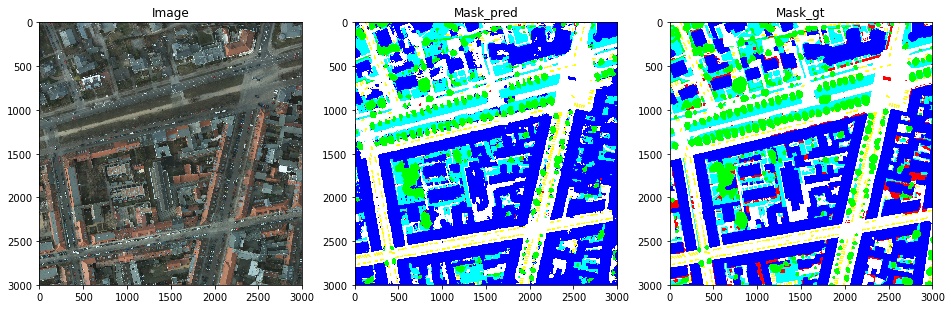

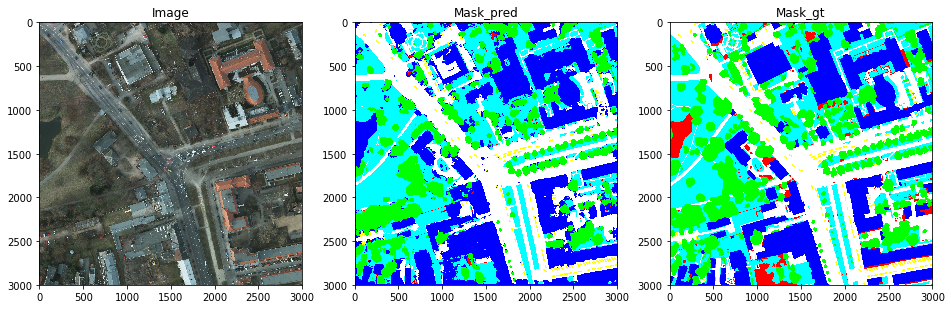

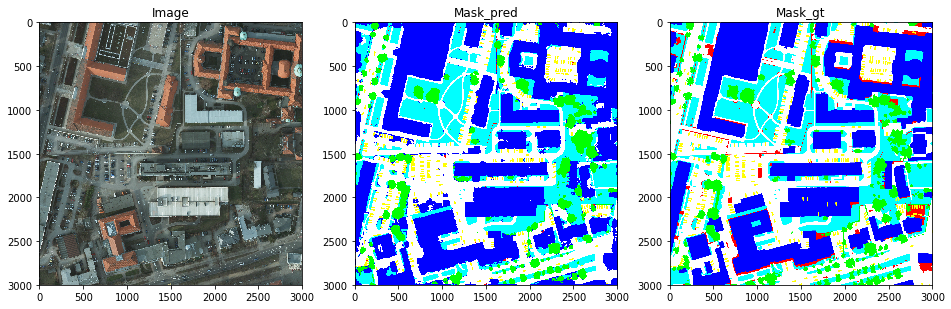

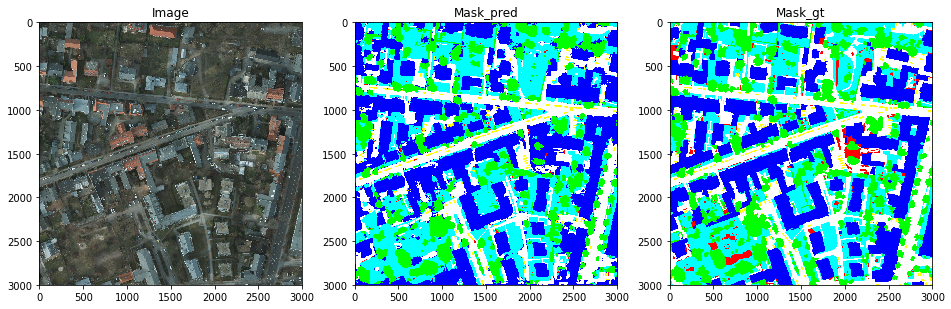

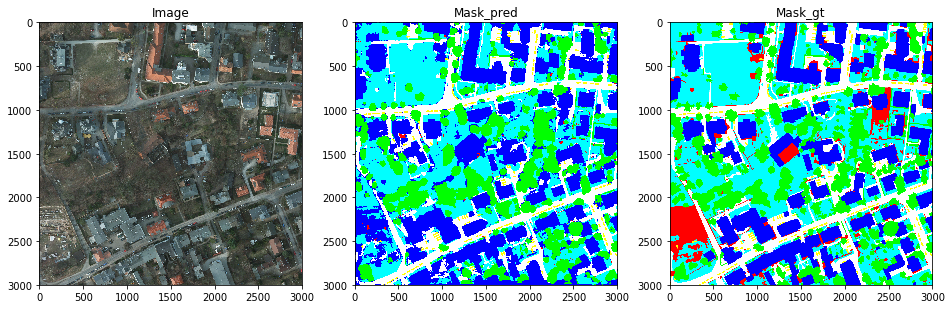

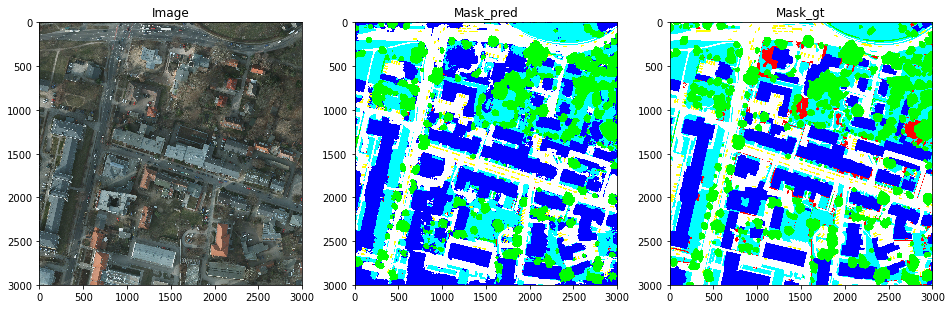

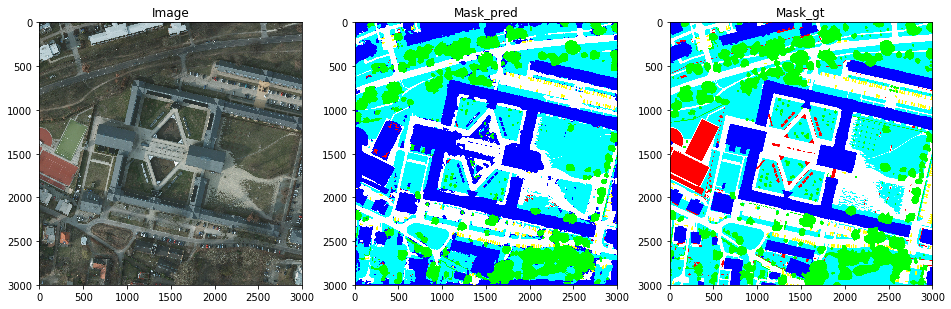

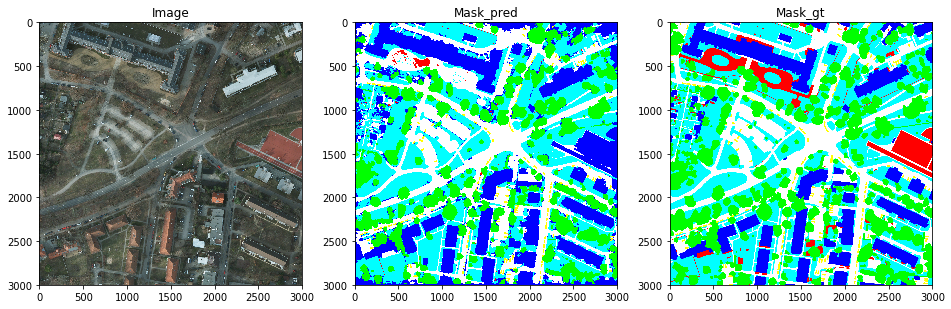

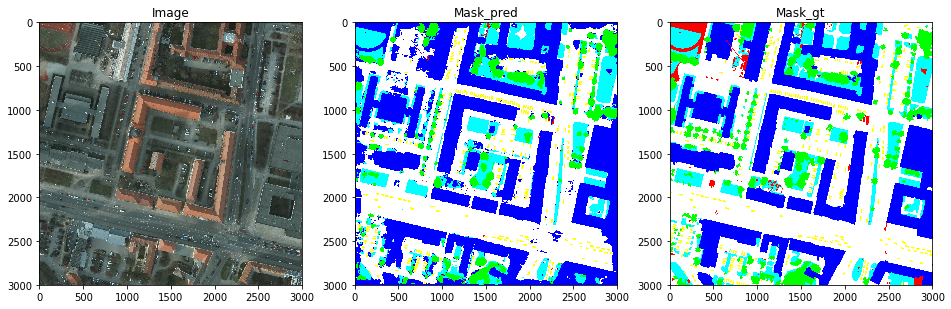

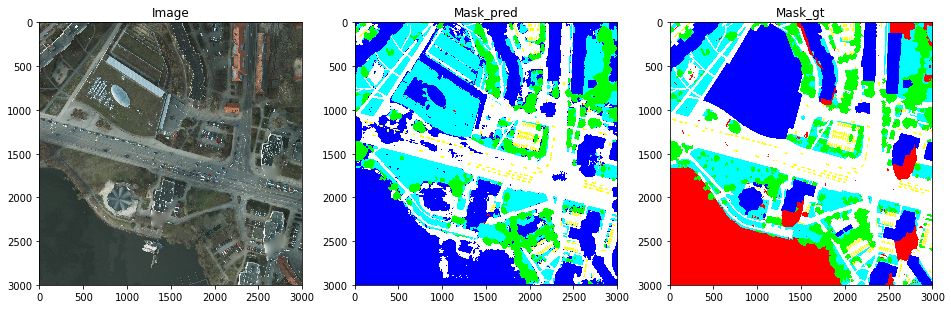

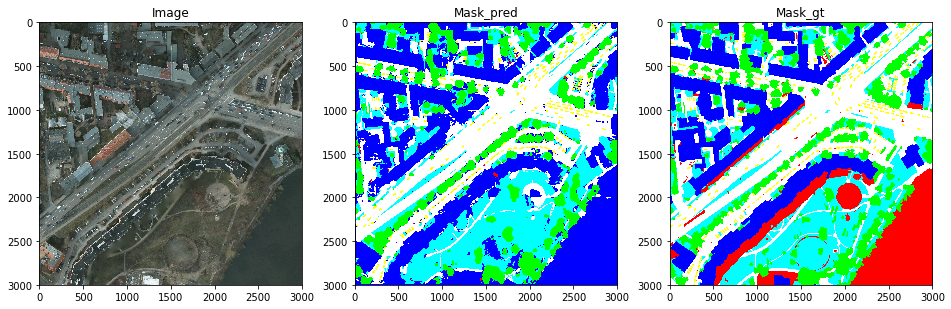

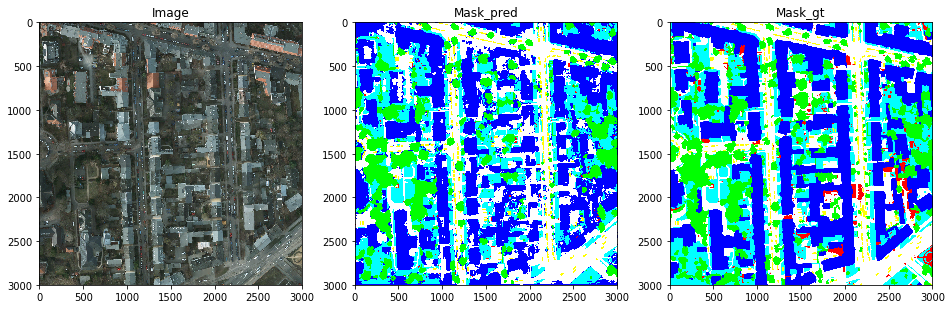

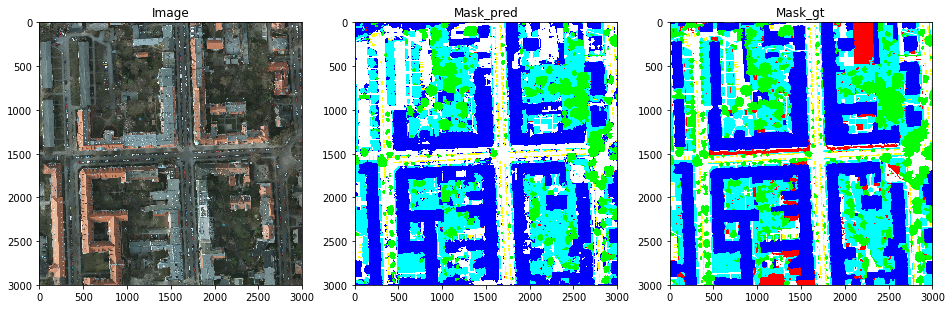

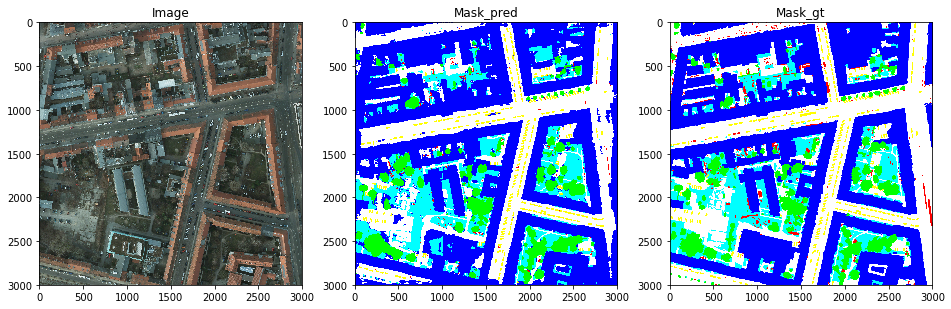

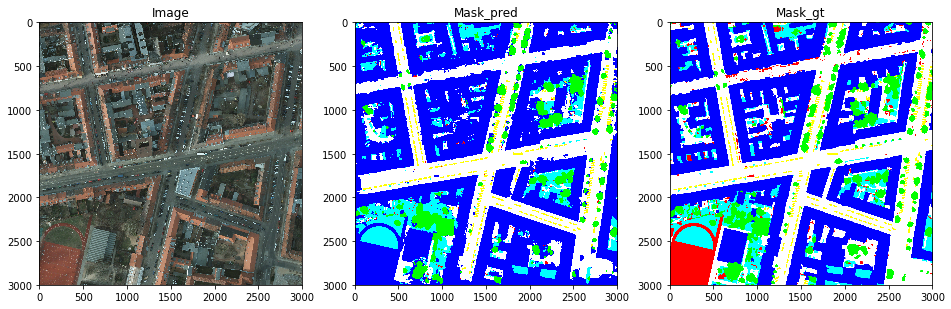

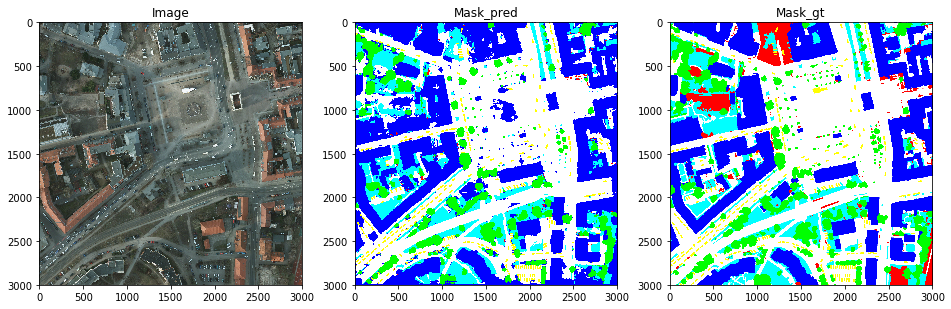

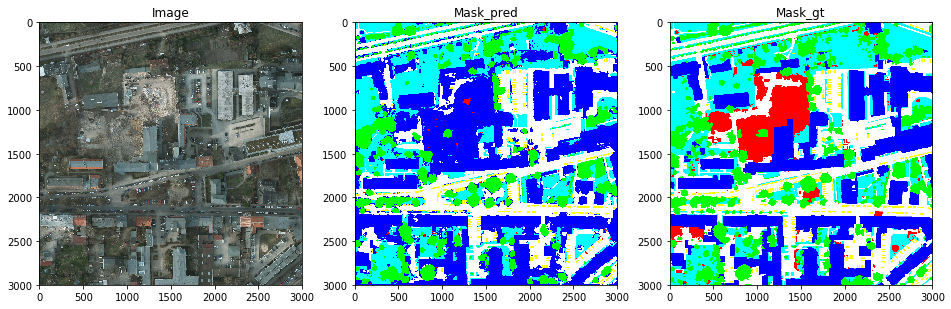

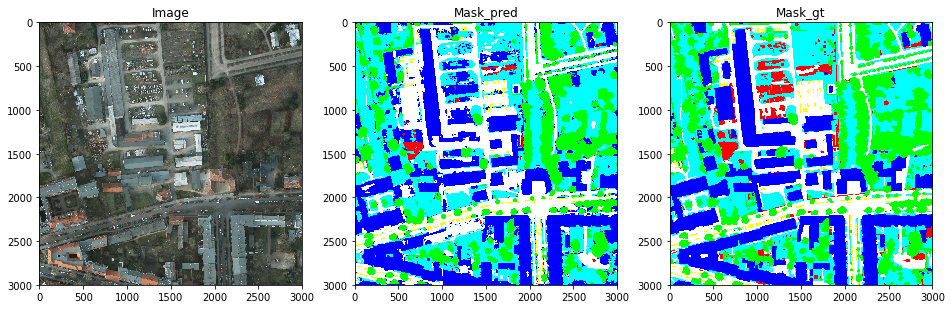

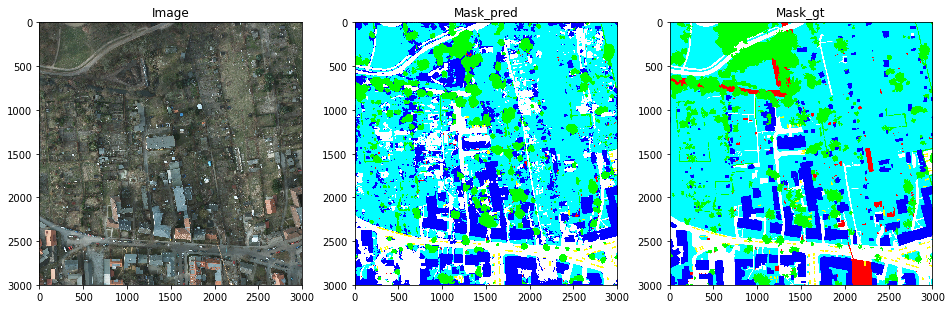

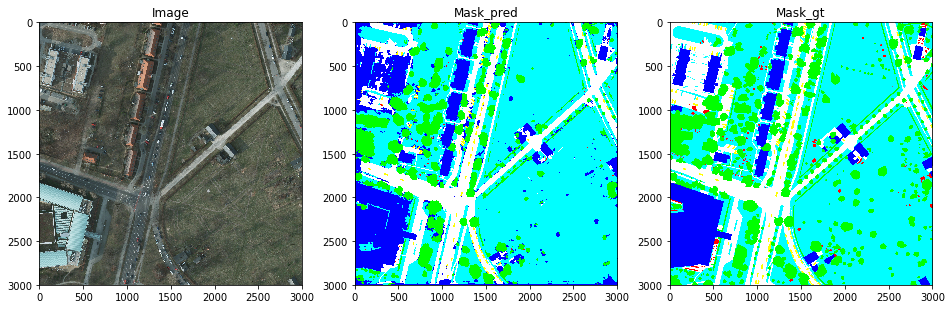

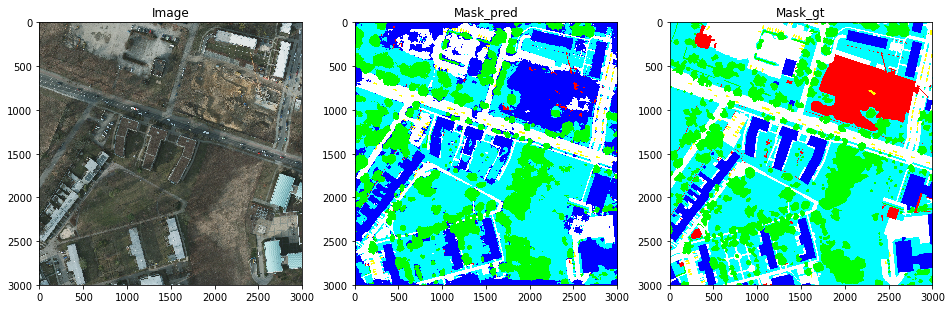

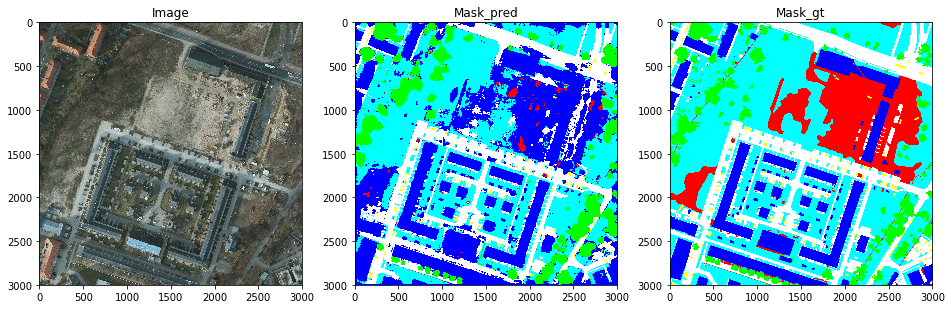

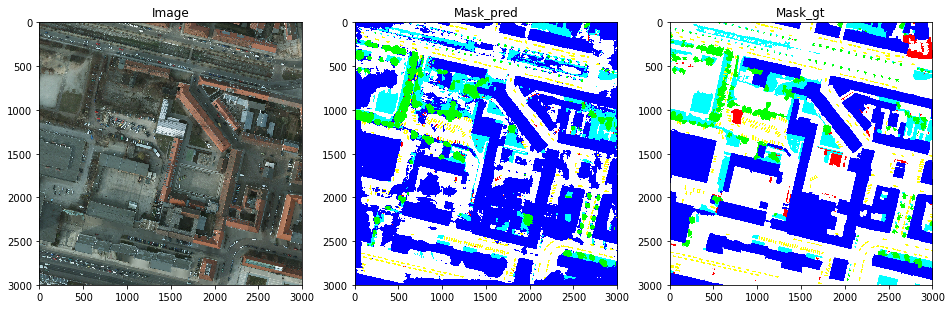

In [28]:
import pandas as pd

jaccards = []

mask_paths = os.listdir(MASK_DIR)
mask_paths_tif = []
for mask_path in mask_paths[::-1]:
    if mask_path.find('.tif') != -1:
        mask_paths_tif.append(mask_path)
        
for mask_path in mask_paths_tif:
    print mask_path
    mask = tif.imread(os.path.join(MASK_DIR, mask_path))
    image = tif.imread(os.path.join(IMAGE_DIR, mask_path.replace('label', 'RGBIR')))
    mask = img_as_ubyte(transform.resize(mask, [3000,3000,3]))
    image = transform.resize(image, [3000,3000,4])
    jaccard = model.predict_visualize_RGB(image, mask, jaccard=True, save_path = "../predictions/predictions_02_06_one_vs_all/%s" % mask_path.replace('tif', 'jpg'), order=None)
    print jaccard
    jaccards.append(jaccard)
        
print jaccards
df = pd.DataFrame(np.array(jaccards))
image_paths_tif = [path.replace('label', 'RGBIR') for path in mask_paths_tif]
df.insert(loc=0, value=image_paths_tif, column='path')
df.to_csv('../predictions/predictions_02_06_one_vs_all/results.csv')

In [38]:
category_code = {
            0: [0, 0, 255],
            1: [0, 255, 0],
            2: [0, 255, 255],
            3: [255, 0, 0],
            4: [255, 255, 0],
            5: [255, 255, 255],
        }

def predict_visualize_RGB(image, mask_gt=None, masks_pred = None, order=(5, 0, 1, 2, 4, 3), jaccard=False):
    """ Viusalize the raw image, ground truth and predicted mask
    Mask overlap order: Road, Building, Grass, Tree, Car, Unknown

    :param image: raw image in numpy (N, H, W, C)
    :param mask: mask ground truth in numpy (N, H, W, C)
    """
    height, width = masks_pred.shape[:2]
    mask_pred = np.zeros(shape=(height, width, 3), dtype=np.uint8)
    # use category color code to colorate the mask_pred
    for i in order:
        mask_category = masks_pred[..., i]
        colors = category_code[i]
        for channel, color in enumerate(colors):
            mask_pred[..., channel][mask_category.astype(np.bool)] = color

            # plot image, mask_gt, mask_pred
        plt.figure(figsize=(16, 16))

    # plot image
    if mask_gt is None:
        plt.subplot(1, 2, 1)
    else:
        plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(image[..., :3])

    # plot mask_pred
    if mask_gt is None:
        plt.subplot(1, 2, 2)
    else:
        plt.subplot(1, 3, 2)
    plt.title("Mask_pred")
    plt.imshow(mask_pred)

    # plot mask_gt
    if mask_gt is None:
        plt.show()
        return
    else:
        plt.subplot(1, 3, 3)
        plt.title("Mask_gt")
        plt.imshow(mask_gt)

    # show all
    plt.show()
            
    jaccards = []
    # compute jaccard index
    if mask_gt is not None and jaccard:
        masks_pred = _rgb2masks(mask_pred)
        masks_gt = _rgb2masks(mask_gt)

        for i in range(len(category_code)):
            jaccards.append(_jaccard_index(masks_gt[..., i], masks_pred[..., i]))
        return jaccards
    
def _jaccard_index(y_true, y_pred):

    intersection = (y_true & y_pred).sum()
    sum_ = (y_true | y_pred).sum()

    jaccard = (intersection + smooth) / (sum_ + smooth)

    return jaccard

def _rgb2masks(mask):
    height, width = mask.shape[:2]
    masks = np.zeros(shape=(height, width, len(category_code)), dtype=np.bool)
    for i in range(len(category_code)):
        R, G, B = category_code[i]
        masks[..., i] = (mask[..., 0] == R) & (mask[..., 1] == G) & (mask[..., 2] == B)
    return masks

In [38]:
import skimage.io as io

DIR = "../predictions/"
paths = os.listdir(DIR)
paths.remove("IOU.csv")
print paths

['top_potsdam_5_12_label.jpg', 'top_potsdam_5_11_label.jpg', 'top_potsdam_5_10_label.jpg', 'top_potsdam_4_12_label.jpg', 'top_potsdam_4_11_label.jpg', 'top_potsdam_4_10_label.jpg', 'top_potsdam_3_12_label.jpg', 'top_potsdam_3_11_label.jpg', 'top_potsdam_3_10_label.jpg', 'top_potsdam_7_11_label.jpg', 'top_potsdam_7_10_label.jpg', 'top_potsdam_7_9_label.jpg', 'top_potsdam_7_8_label.jpg', 'top_potsdam_7_7_label.jpg', 'top_potsdam_6_12_label.jpg', 'top_potsdam_6_11_label.jpg', 'top_potsdam_6_10_label.jpg', 'top_potsdam_6_9_label.jpg', 'top_potsdam_6_8_label.jpg', 'top_potsdam_6_7_label.jpg', 'top_potsdam_2_12_label.jpg', 'top_potsdam_2_11_label.jpg', 'top_potsdam_2_10_label.jpg', 'top_potsdam_7_12_label.jpg']


In [43]:
OUTPUT_PATH = "../output"
for path in paths:
    img = io.imread(os.path.join(DIR, path))
    io.imsave(os.path.join(OUTPUT_PATH, path), img[360:800])